In [ ]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn import metrics

In [ ]:
# Lendo o dataset
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iris.csv')
dataset.head()

Variável target será a classe, portanto, devemos montar uma rede que realize a predição correta da classe, dadas as features. (multiclass classification problem)

# Pré processamento dos dados

In [ ]:
# Verificar o tipo de dado das colunas do Dataset
dataset.dtypes

sepalLengthInCM    float64
sepalWidthInCM     float64
petalLengthInCM    float64
petalWidthInCM     float64
class               object
dtype: object

Teremos que transformar o dado categórico "class" para um vetor one-hot que representa a camada de saída da rede, mas antes, vamos analizar as variáveis de entrada:

verificando a integridade dos dados prresentes nas features

In [ ]:
# Percentual de dados faltantes na base
dataset.isnull().mean() *100

sepalLengthInCM    0.0
sepalWidthInCM     0.0
petalLengthInCM    0.0
petalWidthInCM     0.0
class              0.0
dtype: float64

In [ ]:
# observando a distribuição dos dados
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sepalLengthInCM,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepalWidthInCM,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petalLengthInCM,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petalWidthInCM,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


SepalLenghtInCM

<Axes: ylabel='Frequency'>

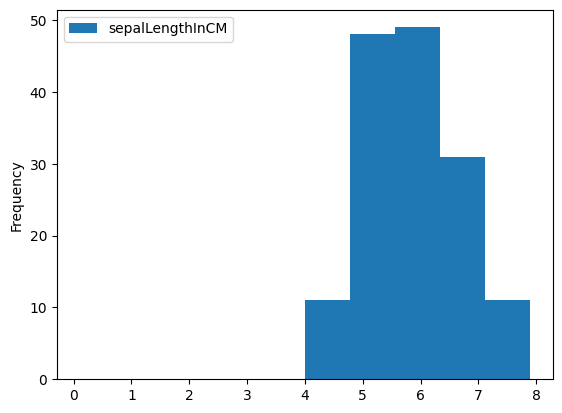

In [ ]:
# Histograma
dataset.plot.hist(column=["sepalLengthInCM"])

<Axes: >

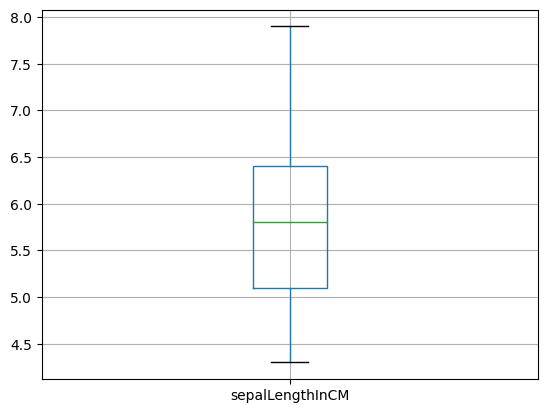

In [ ]:
# observando outliers através do Box Plot (método dos quartis)
dataset.boxplot(column=["sepalLengthInCM"])

Analizando os resultados, podemos perceber que não foi encontrado nenhum outlier no atributo sepalLengthInCM

sepalWidthInCM

<Axes: ylabel='Frequency'>

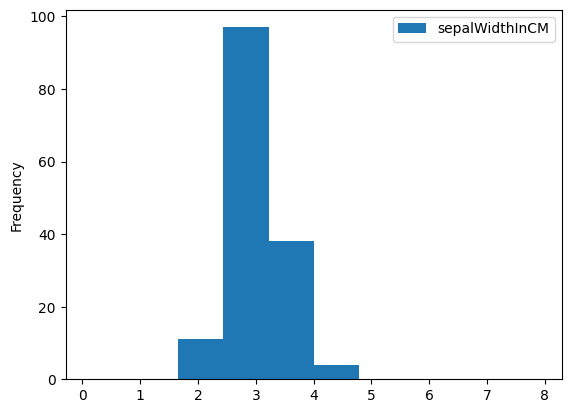

In [ ]:
# Histograma
dataset.plot.hist(column=["sepalWidthInCM"])

<Axes: >

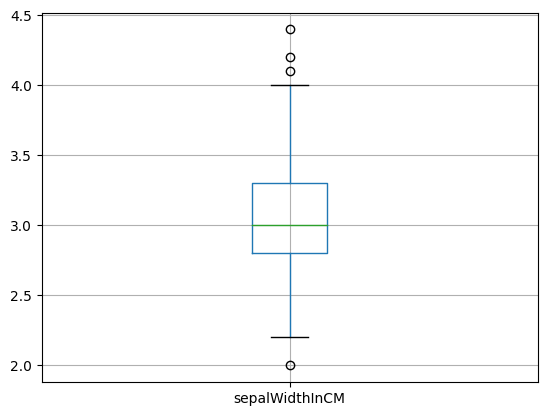

In [ ]:
# observando outliers através do Box Plot (método dos quartis)
dataset.boxplot(column=["sepalWidthInCM"])

Analizando os resultados, vemos que foram encontrados 3 outliers superiores e 1 inferior no atributo sepalWidthInCM. Porém, sabendo que os valores desses outliers são bem próximos aos valores encontrados nos dados e assumindo a possibilidade de que esses valores possam de fato existir neste atributo, foi tomada a escolha de manter essas instâncias no dataset.

petalLengthInCM

<Axes: ylabel='Frequency'>

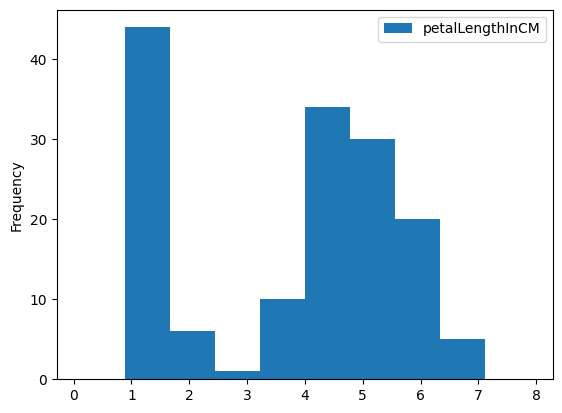

In [ ]:
# Histograma
dataset.plot.hist(column=["petalLengthInCM"])

<Axes: >

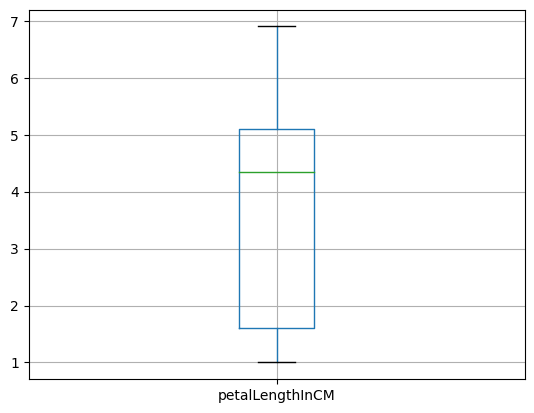

In [ ]:
# observando outliers através do Box Plot (método dos quartis)
dataset.boxplot(column=["petalLengthInCM"])

Analizando os resultados, podemos perceber que não foi encontrado nenhum outlier no atributo petalLengthInCM

petalWidthInCM

<Axes: ylabel='Frequency'>

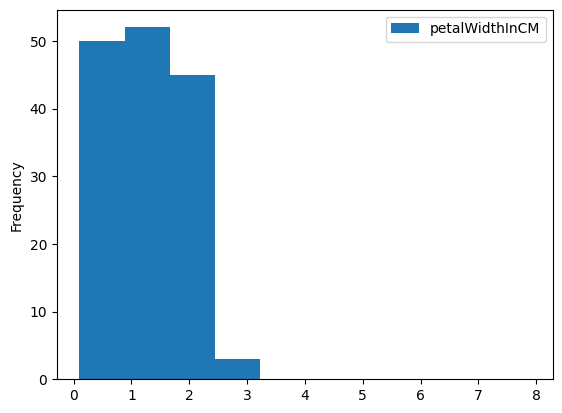

In [ ]:
# Histograma
dataset.plot.hist(column=["petalWidthInCM"])

<Axes: >

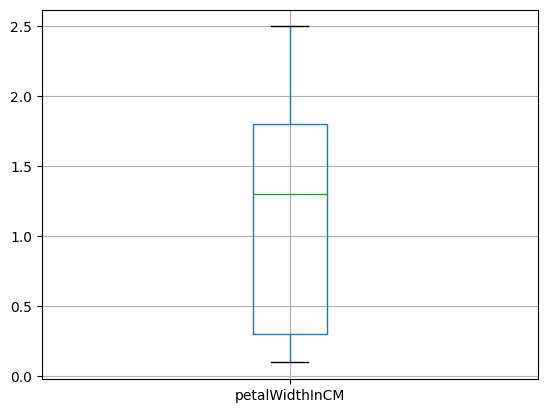

In [ ]:
# observando outliers através do Box Plot (método dos quartis)
dataset.boxplot(column=["petalWidthInCM"])

Analizando os resultados, podemos perceber que não foi encontrado nenhum outlier no atributo sepalLengthInCM

## Tratando a variável target

In [ ]:
# obtendo as classes presentes no dataset
dataset['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Gerando variáveis dummies e transformando a variável target em um one-hot vector.

In [ ]:
#transformando a variável target do dataset em um vetor one-hot
target_dummies = pd.get_dummies(dataset["class"])
target_dummies.head()

,Iris-setosa,Iris-versicolor,Iris-virginica
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [ ]:
target_dummies.dtypes

Iris-setosa        uint8
Iris-versicolor    uint8
Iris-virginica     uint8
dtype: object

In [ ]:
# podemos facilmente obter as classes novamente da seguinte forma
target = target_dummies.idxmax(axis=1)
target.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Observando o balanceamento dos dados

In [ ]:
# instancias por classe
target_dummies.sum(axis=0)

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

Logo, podemos observar que os dados estão perfeitamente balanceados!



---



# Definindo parâmetros

In [ ]:
# Definindo alguns parâmetros

# atributos do dataset que serão usados
# utilizando inicialmente todos os atributos
features = ["sepalLengthInCM", 	"sepalWidthInCM", 	"petalLengthInCM", 	"petalWidthInCM"]
classes = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

# número de divisões do K-fold
kf_splits = 5

# parâmetros para a rede:
# n_hiddenLayers = 1
# n_nodesPerLayer = 2
hidden_layer_sizes = [2]
# max_epoch: default = 500
max_epoch = 500
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.001

# Divisão dos dados em treinamento e teste
Utilizando 90% do dataset para treino, e deixando o conjunto de testes com 5 instancias de cada classe. Além disso, Normalizando os dados de entrada

In [ ]:
# função que gera os conjuntos de treino e teste de forma pseudo-aleatória
def generateTrainTest(X, y):
  scaler = StandardScaler()
  X = pd.DataFrame(scaler.fit_transform(X), columns = list(X.columns.values))

  rnd = np.random.randint(1000)
  X_class = [[],[],[]]
  y_class = [[],[],[]]
  # separando o conjunto por classes
  for i in range(len(y.index)):
    if(y["Iris-setosa"][i] == 1):
      X_class[0].append(X.iloc[[i]])
      y_class[0].append(y.iloc[[i]])
    elif(y["Iris-versicolor"][i] == 1):
      X_class[1].append(X.iloc[[i]])
      y_class[1].append(y.iloc[[i]])
    else:
      X_class[2].append(X.iloc[[i]])
      y_class[2].append(y.iloc[[i]])


  X_train = []
  X_test = []
  y_train = []
  y_test = []
  # gerando um train test split para cada classe
  for i in range(3):
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(pd.concat(X_class[i]), pd.concat(y_class[i]), test_size=0.10, random_state=rnd)
    X_train.append(X_class_train)
    X_test.append(X_class_test)
    y_train.append(y_class_train)
    y_test.append(y_class_test)


  return pd.concat(X_train), pd.concat(X_test), pd.concat(y_train), pd.concat(y_test), scaler

In [ ]:
# Gerando o conjunto de treino, teste e scaler para normalização
X_train, X_test, y_train, y_test, scaler = generateTrainTest(dataset[features], target_dummies)

In [ ]:
# instancias de treino
X_train.count()

sepalLengthInCM    135
sepalWidthInCM     135
petalLengthInCM    135
petalWidthInCM     135
dtype: int64



---






In [ ]:
# instancias de teste
X_test.count()

sepalLengthInCM    15
sepalWidthInCM     15
petalLengthInCM    15
petalWidthInCM     15
dtype: int64

In [ ]:
# instancias por classe
y_test.sum(axis=0)

Iris-setosa        5
Iris-versicolor    5
Iris-virginica     5
dtype: int64

# Criação do modelo para predição
Usando k-fold para treinamento e validação

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Observando a estrutura do modelo...

De acordo com a documentação, o sklearn define automaticamente as camadas de entrada e saída de acordo com os dados utilizados no fit:

In [ ]:
# input layer -> numero de features
print("Input layer: ", X_train.shape[1])
print("(cada valor no array representa o numero de neurônios na camada) \nHidden layers: ", hidden_layer_sizes)
# output layer -> variáveis criadas na transformação one-hot (número de classes)
print("Output layer: ", y_train.shape[1])

Input layer:  4
(cada valor no array representa o numero de neurônios na camada) 
Hidden layers:  [2]
Output layer:  3


Treinando o modelo utilizando o k-fold

In [ ]:
# função que exibe as métiricas do treinamento k-fold de um modelo
def printMetrics(KFmetrics):
  acc_train_fold, acc_valid_fold, train_fold_f1, valid_fold_f1 = KFmetrics
  print("Acurácia por fold ")
  print("Conjunto de treino:     ", list(np.around(acc_train_fold,2)))
  print("Conjunto de validação: ", list(np.around(acc_valid_fold,2)))

  print("\nAcurácia média no Conjunto de treino:     ", np.around(np.mean(acc_train_fold),2))
  print("Acurácia média no Conjunto de validação: ", np.around(np.mean(acc_valid_fold),2))

  print("\nF1-Score macro avg por fold")
  print("Conjunto de treino:     ", list(np.around(train_fold_f1,2)))
  print("Conjunto de validação: ", list(np.around(valid_fold_f1,2)))

  print("\nF1-Score médio no Conjunto de treino:     ", np.around(np.mean(train_fold_f1),2))
  print("F1-Score médio no Conjunto de validação: ", np.around(np.mean(valid_fold_f1),2))

# função que realiza o K-fold e obtém as métricas do classificador gerado pelo modelo
def runKFold(model, kf_splits, X_train, y_train):
  kf = KFold(n_splits=kf_splits, shuffle = True)

  # guarda cada uma das acurácias
  acc_train_fold = []
  acc_valid_fold = []

  # guarda cada um dos f1 scores
  train_fold_f1 = []
  valid_fold_f1 = []

  # variáveis temporárias para guardar os dados obtidos em um fold
  X_train_fold, X_valid_fold = [],[]
  y_train_fold, y_valid_fold = [],[]

  # guarda os valores de loss por época de cada fold
  lossCurves = []

  for train_index, valid_index in kf.split(X_train):
    # dividindo os conjuntos de teste e validação
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Usamos o método fit para construir o classificador a partir do nosso conjunto de treinamento
    classifier = model.fit(X_train_fold, y_train_fold)

    # guardado a loss curve do fold
    lossCurves.append(classifier.loss_curve_)

    # obtendo as predições como probabilidades
    y_pred_train = classifier.predict_proba(X_train_fold)
    y_pred_valid = classifier.predict_proba(X_valid_fold)
    # indicando a maior probabilidade como a provável predição
    for row in range(y_pred_train.shape[0]):
      for col in range(y_pred_train.shape[1]):
        if(y_pred_train[row, col] == y_pred_train[row, :].max()):
          y_pred_train[row, col] = 1
        else:
          y_pred_train[row, col] = 0
    for row in range(y_pred_valid.shape[0]):
      for col in range(y_pred_valid.shape[1]):
        if(y_pred_valid[row, col] == y_pred_valid[row, :].max()):
          y_pred_valid[row, col] = 1
        else:
          y_pred_valid[row, col] = 0

    # transformando os dados de one-hot para classes
    y_pred_train = pd.DataFrame(y_pred_train, columns = classes).idxmax(axis=1)

    y_pred_valid = pd.DataFrame(y_pred_valid, columns = classes).idxmax(axis=1)

    y_train_fold = pd.DataFrame(y_train_fold, columns = classes).idxmax(axis=1)

    y_valid_fold = pd.DataFrame(y_valid_fold, columns = classes).idxmax(axis=1)

    # valores de acurácia
    acc_train = metrics.accuracy_score(y_train_fold, y_pred_train)
    acc_valid = metrics.accuracy_score(y_valid_fold, y_pred_valid)

    # adiciona a acurácia à lista
    acc_train_fold.append(acc_train)
    acc_valid_fold.append(acc_valid)

    # valores de f1
    f1_train = metrics.f1_score(y_train_fold, y_pred_train, average = "macro")
    f1_valid = metrics.f1_score(y_valid_fold, y_pred_valid, average = "macro")

    # adiciona o f1 à lista
    train_fold_f1.append(f1_train)
    valid_fold_f1.append(f1_valid)

  # cria a matriz de confusão do conjunto de validação do ultimo fold
  #print(y_valid_fold)
  cm = metrics.confusion_matrix(y_valid_fold.to_numpy(), y_pred_valid.to_numpy(), labels = classes)

  return classifier, lossCurves, cm, (acc_train_fold, acc_valid_fold, train_fold_f1, valid_fold_f1)

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Como podemos observar, o modelo não atinge convergência dados os parametros definidos. Como alternativa para a resolução desse problema, podemos aumentar o numero de épocas ou até mesmo aumentar o learning rate.

In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [0.68, 0.63, 0.36, 0.71, 0.62]
Conjunto de validação:  [0.59, 0.63, 0.15, 0.52, 0.7]

Acurácia média no Conjunto de treino:      0.6
Acurácia média no Conjunto de validação:  0.52

F1-Score macro avg por fold
Conjunto de treino:      [0.54, 0.52, 0.27, 0.6, 0.51]
Conjunto de validação:  [0.49, 0.6, 0.13, 0.56, 0.61]

F1-Score médio no Conjunto de treino:      0.49
F1-Score médio no Conjunto de validação:  0.48


Podemos observar também que no conjunto de validação os resultados obtidos foram bem ruins, pois a acurácia e o f1-score para alguns dos folds foi bem baixo, tornando o modelo instável.

Plotando a curva de perda de cada fold

In [ ]:
# Função que plota o gráfico Loss por época
def lossPlot(lossCurves, max_epoch):
  fig, ax = plt.subplots()
  fold = 1
  for curve in lossCurves:
    epoch = range(1, max_epoch+1)
    convergence = curve[-1]
    for _ in range(max_epoch-len(curve)):
      curve.append(convergence)
    ax.plot(epoch, curve, label = 'Fold ' + str(fold) + ' Loss')
    fold += 1

  # finalziando o plot
  plt.title('Função Loss por Época')
  plt.xlabel('Época') #x label
  plt.ylabel('Loss') #y label
  plt.yscale('linear')
  plt.legend()
  plt.show()


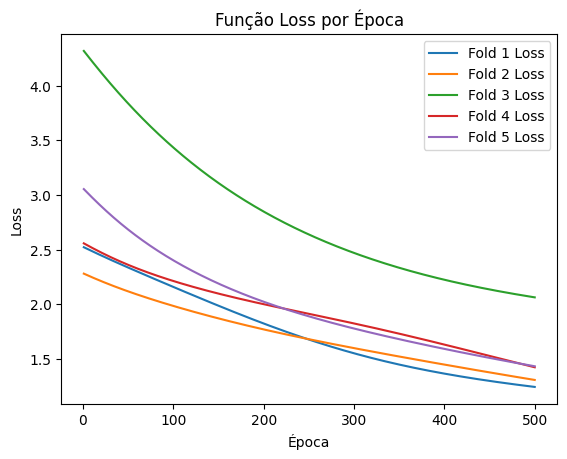

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

Como visto anteriormente, Ainda não foi atingida a convergência, com o intúito de atingir esse resultado, estaremos mudando alguns parâmetros posteriormente. No entanto, mesmo ao alcançar uma estabilidade na função de perda, talvez a estrutura desta rede não consiga classificar precisamente e consistentemente todas as classes presentes no dataset, provavelmente precisando de algum tipo de mudança em sua estrutura de camadas escondidas.

Observando a matriz de confusão do conjunto de validação do último fold

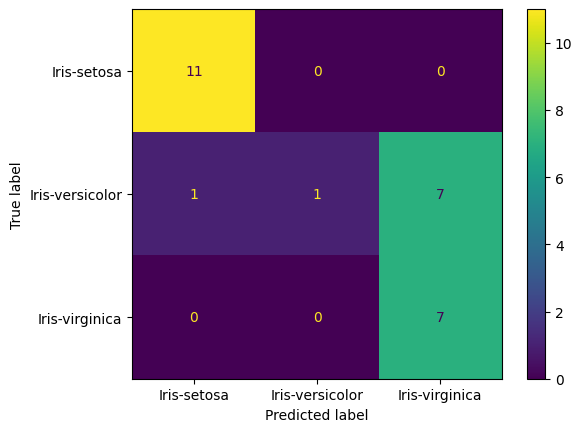

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();

Observando a matriz de confusão, vê-se que o classificador acertou uma boa quantidade de instâncias da classe Iris-virginica e Iris-setosa porém errou consideravelmente a versicolor. Isso explica o F1-Score ruim no conjunto de validação. Apesar disso, devemos nos atentar que devido à instabilidade do modelo a matriz de confusão do último fold pode variar muito, não sendo uma boa métrica de avaliação, por este motivo, esta métrica será omitida em alguns experimentos do relatório.



---

# Aplicando mudanças na rede

Agora, sem a restrição de utilizar todas as variáveis de entrada, vamos realizar uma seleção de atributos, possivelmente proporcionando um melhor desempenho do modelo ao mesmo tempo que sua complexidade é diminuida, pois a input layer estará menor.

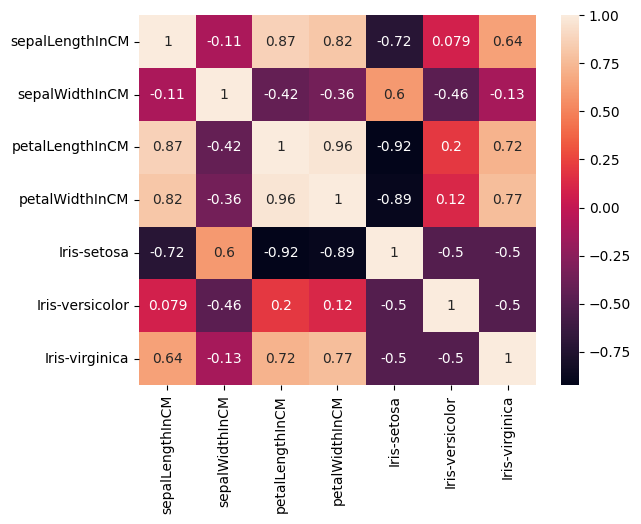

In [ ]:
dataset_corr = pd.concat([dataset, target_dummies], axis = 1)
dataset_corr = dataset_corr.drop('class', axis=1)
# gerando a matriz de correlação das features
corr = dataset_corr.corr(method = 'pearson')
sn.heatmap(corr, annot=True)
plt.show()

A partir correlação gerada acima, podemos extrair as seguintes informações por classe:
  - Atributos Com alta correlação à Iris-setosa:
    - Sepal length
    - Petal length
    - Petal width
  - Atributos Com alta correlação à Iris-versicolor:
    - Sepal width
  - Atributos Com alta correlação à Iris-virginica:
    - Sepal length
    - Petal length
    - Petal width

Portanto, infelizmente não poderemos deixar de usar nenhum atributo de entrada, já que todos eles contribuiem com relativamente alta correlação na classificação de uma Iris.

## Learning Rate

Como dito anteriormente, começaremos com uma mudança que possa implicar na convergência do modelo ao treinar-lo. Inicialmente, aumentaremos uma escala decimal a taxa de aprendizado "learning_rate_init = 0.01" para tentar ajustar melhor os pesos da rede mantendo o mesmo número de épocas para treinamento.

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [2]
# max_epoch: default = 500
max_epoch = 500
activation_f = "identity"
solver = "adam"
#learning_rate_init: default = 0.001 -> 0.01
learning_rate_init = 0.01

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Rodando k-fold e obtendo as métricas

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [0.94, 0.96, 0.96, 0.98, 0.96]
Conjunto de validação:  [0.89, 1.0, 0.93, 0.96, 0.96]

Acurácia média no Conjunto de treino:      0.96
Acurácia média no Conjunto de validação:  0.95

F1-Score macro avg por fold
Conjunto de treino:      [0.93, 0.96, 0.96, 0.98, 0.96]
Conjunto de validação:  [0.9, 1.0, 0.9, 0.97, 0.96]

F1-Score médio no Conjunto de treino:      0.96
F1-Score médio no Conjunto de validação:  0.95


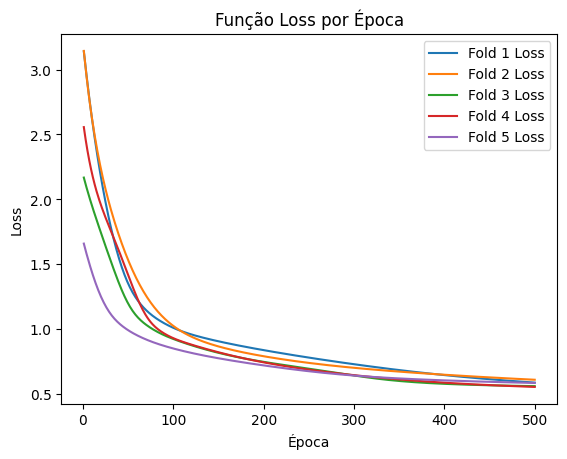

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

Conseguimos observar que, apesar do aviso de não convergência para uma tolerância 1e-6 entre 50 iterações do otimizador, o modelo apresenta uma loss curve que se aproxima bastante da convergência, com um decaimento inicial muito mais abrupto e, nas épocas finais, sem muitas mudanças. Além disso, as métricas de acurácia e F1-Score tiveram um resultado muito melhor.

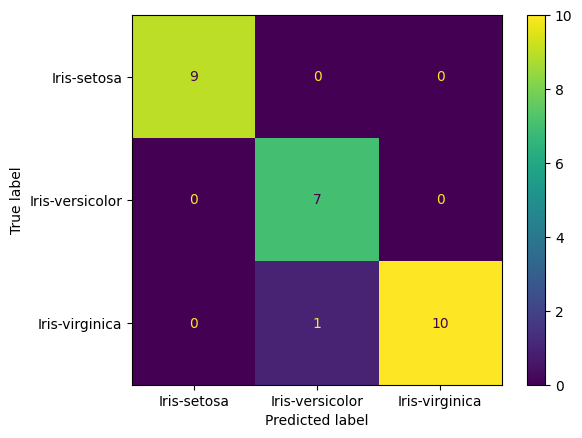

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();

# Número de épocas

a quesito de curiosidade, extrapolarei o número de épocas (aumentando em uma escala decimal) para observar o que irá acontecer com o warning de não convergência, na esperança de que alcancemos uma mudança do valor Loss menor que 1e-6 entre 50 iterações do otimizador (esse é o valor defaut n_iter_no_change). Esta mudança está sendo aplicada a partir dos parametros defaut, sem a mudança anterior.

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [2]
# max_epoch: default = 500
max_epoch = 5000
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.001

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Rodando k-fold e obtendo as métricas

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [0.97, 0.95, 0.96, 0.95, 0.95]
Conjunto de validação:  [0.93, 0.89, 0.93, 1.0, 1.0]

Acurácia média no Conjunto de treino:      0.96
Acurácia média no Conjunto de validação:  0.95

F1-Score macro avg por fold
Conjunto de treino:      [0.97, 0.95, 0.96, 0.95, 0.96]
Conjunto de validação:  [0.94, 0.89, 0.92, 1.0, 1.0]

F1-Score médio no Conjunto de treino:      0.96
F1-Score médio no Conjunto de validação:  0.95


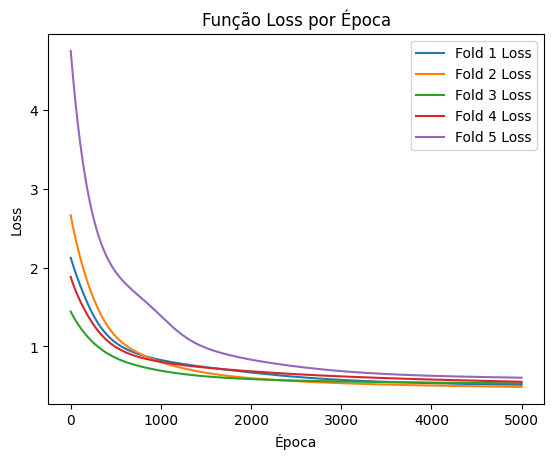

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

Mantendo o learning rate defautl, e aumentando o número de épocas, foi possível atingir bons valores de métricas, com a curva Loss aparentemente se mantendo estável no final. Entretanto, não conseguimos eliminar o warning de convergência. Isto pode indicar uma insuficiencia do próprio modelo, continuamos as mudanças dos parâmetros com base nesta hipótese.

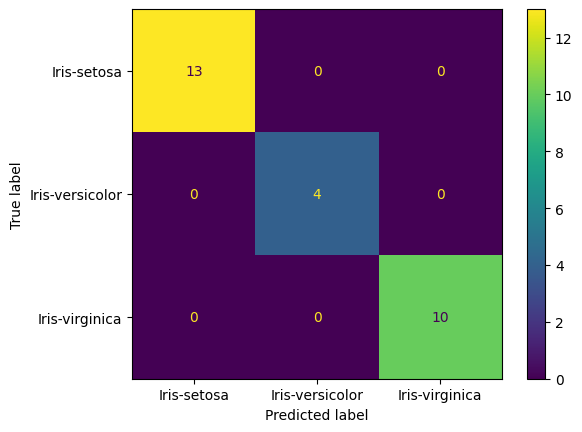

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();

# Neurons na Hidden layer

Aumentando a complexidade da rede (4 neurons em uma camada escondida, igualando o numero de neurons da input layer), talvez consigamos algum mecanismo mais potente de classificação, podemos também verificar posteriormente a convergência do modelo e as métricas.

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [4]
# max_epoch: default = 500
max_epoch = 500
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.001

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Rodando k-fold e obtendo as métricas

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [0.85, 0.82, 0.81, 0.85, 0.75]
Conjunto de validação:  [0.89, 0.81, 0.59, 0.96, 0.78]

Acurácia média no Conjunto de treino:      0.82
Acurácia média no Conjunto de validação:  0.81

F1-Score macro avg por fold
Conjunto de treino:      [0.85, 0.82, 0.8, 0.85, 0.72]
Conjunto de validação:  [0.86, 0.83, 0.58, 0.96, 0.72]

F1-Score médio no Conjunto de treino:      0.81
F1-Score médio no Conjunto de validação:  0.79


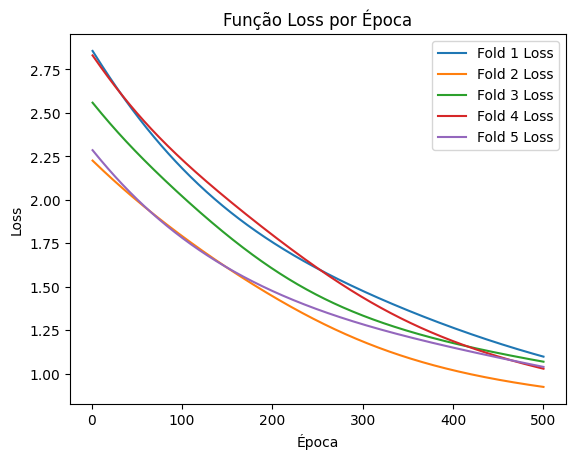

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

No geral, as métricas pioraram, tonando o modelo bem instavel nas predições, mas se combinarmos as melhorias anteriores, proporcionando uma maior margem para a convergência do modelo, talvez consigamos um resultado melhor.

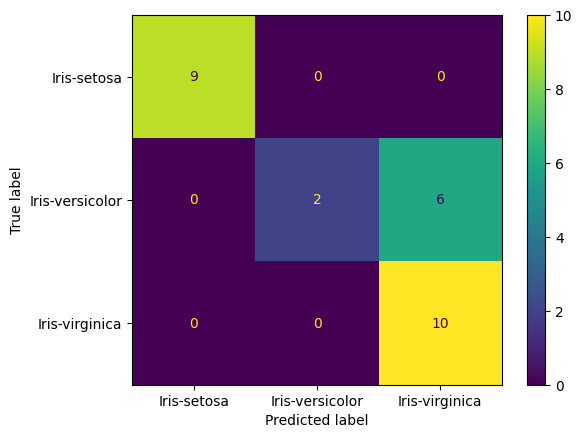

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();

# Camadas na Hidden layer

Aumentando a complexidade da rede (2 camadas escondidas), talvez consigamos algum mecanismo mais potente de classificação, podemos também verificar posteriormente a convergência do modelo e as métricas.

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [2,2]
# max_epoch: default = 500
max_epoch = 500
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.001

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Rodando k-fold e obtendo as métricas

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [0.87, 0.81, 0.69, 0.85, 0.76]
Conjunto de validação:  [0.7, 0.85, 0.59, 0.89, 0.67]

Acurácia média no Conjunto de treino:      0.79
Acurácia média no Conjunto de validação:  0.74

F1-Score macro avg por fold
Conjunto de treino:      [0.86, 0.79, 0.55, 0.85, 0.73]
Conjunto de validação:  [0.68, 0.79, 0.5, 0.88, 0.58]

F1-Score médio no Conjunto de treino:      0.76
F1-Score médio no Conjunto de validação:  0.69


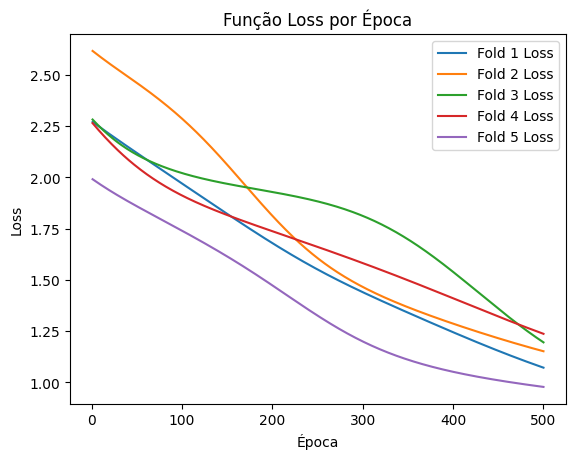

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

No geral, as métricas pioraram, tonando o modelo bem instavel nas predições, mas se combinarmos as melhorias anteriores, proporcionando uma maior margem para a convergência do modelo, talvez consigamos um resultado melhor.

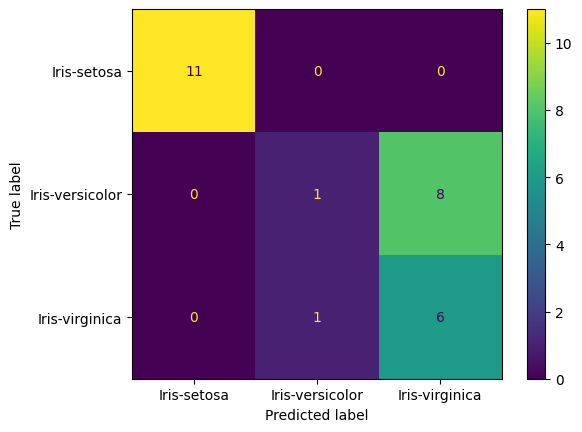

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();

# Combinando melhorias

Como dito anteriormente, aumentando o numero de neurons na hidden layer, precisaremos de mais margem para treinamento para a convergência do modelo, para isso, aumentaremos inicialmente o número de épocas (de 500 para 5000) e learning rate (de 0.001 para 0.01).

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [2]
# max_epoch: default = 500
max_epoch = 5000
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.01

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Rodando k-fold e obtendo as métricas

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [0.96, 1.0, 0.98, 1.0, 0.97]
Conjunto de validação:  [0.96, 0.96, 0.89, 0.96, 1.0]

Acurácia média no Conjunto de treino:      0.98
Acurácia média no Conjunto de validação:  0.96

F1-Score macro avg por fold
Conjunto de treino:      [0.96, 1.0, 0.98, 1.0, 0.97]
Conjunto de validação:  [0.97, 0.97, 0.89, 0.96, 1.0]

F1-Score médio no Conjunto de treino:      0.98
F1-Score médio no Conjunto de validação:  0.96


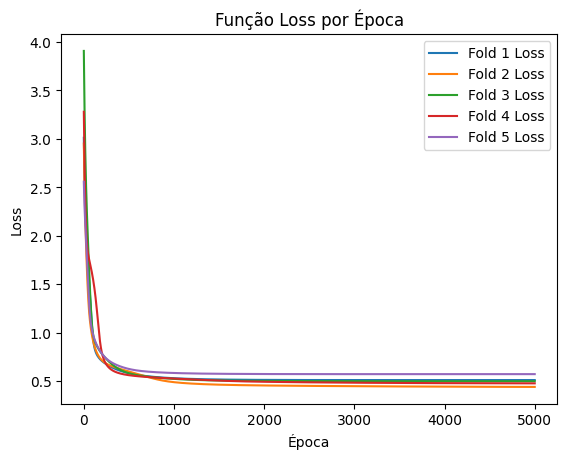

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

Podemos ver que alguns dos modelos no k-fold convergiram, com valores de acurácia e F1-Score bons, tanto para o conjunto de teste quanto de validação. Aplicando somente essas mudanças já conseguimos um bom classificador.

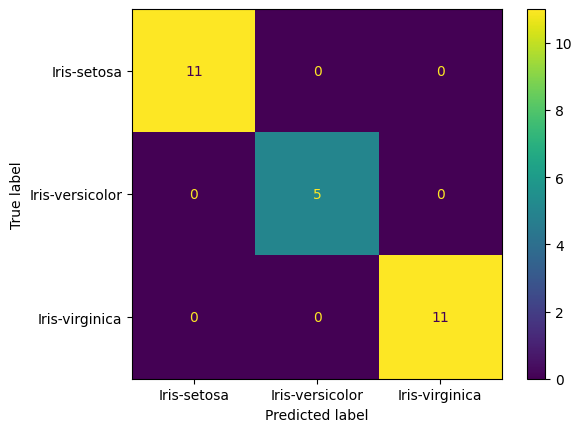

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();

## Aumentando a complexidade da rede com as outras modificações.

Agora que temos uma maior margem para treinamento, podemos aumentar a complexidade da rede, aplicando as modificações experimentadas anteriormente. Teremos agora 2 camadas internas, cada uma com 4 neurônios.

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [4,4]
# max_epoch: default = 500
max_epoch = 5000
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.01

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Rodando k-fold e obtendo as métricas

In [ ]:
# rodando o k-fold para o modelo criado anteriromente
classifier, lossCurves, cm, KFmetrics = runKFold(model, kf_splits, X_train, y_train)

In [ ]:
# printando métricas
printMetrics(KFmetrics)

Acurácia por fold 
Conjunto de treino:      [1.0, 1.0, 0.97, 0.96, 0.97]
Conjunto de validação:  [0.96, 0.89, 0.96, 1.0, 1.0]

Acurácia média no Conjunto de treino:      0.98
Acurácia média no Conjunto de validação:  0.96

F1-Score macro avg por fold
Conjunto de treino:      [1.0, 1.0, 0.97, 0.96, 0.97]
Conjunto de validação:  [0.97, 0.89, 0.96, 1.0, 1.0]

F1-Score médio no Conjunto de treino:      0.98
F1-Score médio no Conjunto de validação:  0.96


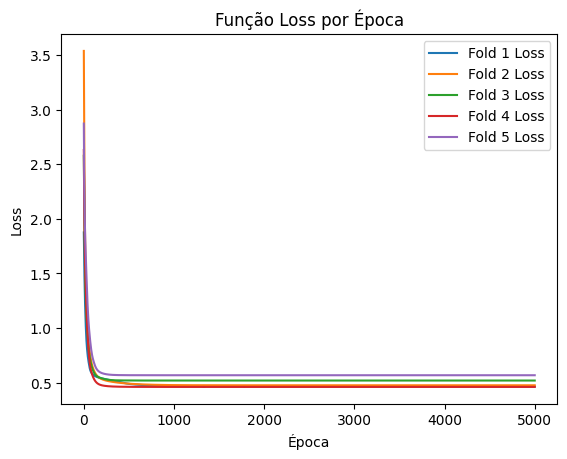

In [ ]:
# Plotando a curva de perda de cada fold
lossPlot(lossCurves, max_epoch)

Podemos ver que todos os modelos no k-fold convergiram, com valores de acurácia e F1-Score bons, tanto para o conjunto de teste quanto de validação.

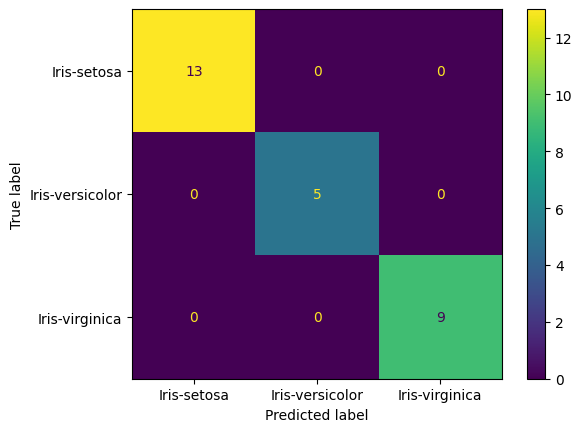

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();



---


# Predição com o melhor modelo

Parâmetros do melhor modelo

In [ ]:
# parâmetros para a rede:
# hidden_layer_sizes: default = [2]
hidden_layer_sizes = [4,4]
# max_epoch: default = 500
max_epoch = 5000
activation_f = "identity"
solver = "adam"
#learning_rate_init: default=0.001
learning_rate_init = 0.01

aplicando parametros em um novo modelo

In [ ]:
model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation_f,
                      solver = solver,
                      learning_rate_init = learning_rate_init,
                      max_iter = max_epoch,
                      tol = 1e-6, # tolerancia para o otimizador determinar convergência da função Loss
                      n_iter_no_change = 50, # determina convergência se a mudança da função Loss é menor que tol durante 50 iterações
                      verbose = False)

Usando os 90% dos dados totais para treino e os 10% separados inicialmente para teste, sem validação desta vez.

In [ ]:
lossCurves = []

# Usamos o método fit para construir o classificador a partir do nosso conjunto de treinamento
classifier = model.fit(X_train, y_train)

# guardado a loss curve
lossCurves.append(classifier.loss_curve_)

# obtendo as predições como probabilidades
y_pred_train = classifier.predict_proba(X_train)
y_pred_test = classifier.predict_proba(X_test)
# indicando a maior probabilidade como a provável predição
for row in range(y_pred_train.shape[0]):
  for col in range(y_pred_train.shape[1]):
    if(y_pred_train[row, col] == y_pred_train[row, :].max()):
      y_pred_train[row, col] = 1
    else:
      y_pred_train[row, col] = 0
for row in range(y_pred_test.shape[0]):
  for col in range(y_pred_test.shape[1]):
    if(y_pred_test[row, col] == y_pred_test[row, :].max()):
      y_pred_test[row, col] = 1
    else:
      y_pred_test[row, col] = 0

# transformando os dados de one-hot para classes
y_pred_train = pd.DataFrame(y_pred_train, columns = classes).idxmax(axis=1)

y_pred_test = pd.DataFrame(y_pred_test, columns = classes).idxmax(axis=1)

y_train = pd.DataFrame(y_train, columns = classes).idxmax(axis=1)

y_test = pd.DataFrame(y_test, columns = classes).idxmax(axis=1)

# valores de acurácia
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)


# valores de f1
f1_train = metrics.f1_score(y_train, y_pred_train, average = "macro")
f1_test = metrics.f1_score(y_test, y_pred_test, average = "macro")

# cria a matriz de confusão do conjunto de validação do ultimo fold
#print(y_valid_fold)
cm = metrics.confusion_matrix(y_test.to_numpy(), y_pred_test.to_numpy(), labels = classes)


In [ ]:
# printando métricas
print("Acurácia no Conjunto de treino: ", np.around(acc_train,2))
print("Acurácia no Conjunto de teste:  ", np.around(acc_test,2))

print("\nF1-Score macro avg no Conjunto de treino: ", np.around(np.mean(f1_train),2))
print("F1-Score macro avg no Conjunto de teste:  ", np.around(np.mean(f1_test),2))

Acurácia no Conjunto de treino:  0.97
Acurácia no Conjunto de teste:   1.0

F1-Score macro avg no Conjunto de treino:  0.97
F1-Score macro avg no Conjunto de teste:   1.0


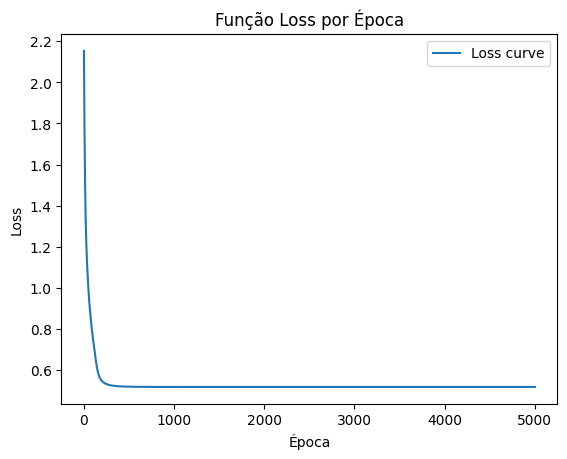

In [ ]:
# Plotando a curva de perda de cada fold
fig, ax = plt.subplots()
for curve in lossCurves:
  epoch = range(1, max_epoch+1)
  convergence = curve[-1]
  for _ in range(max_epoch-len(curve)):
    curve.append(convergence)
  ax.plot(epoch, curve, label = 'Loss curve')

# finalziando o plot
plt.title('Função Loss por Época')
plt.xlabel('Época') #x label
plt.ylabel('Loss') #y label
plt.yscale('linear')
plt.legend()
plt.show()

Podemos ver que o modelo convergiu, com valores de acurácia e F1-Score bons, tanto para o conjunto de teste quanto de validação.

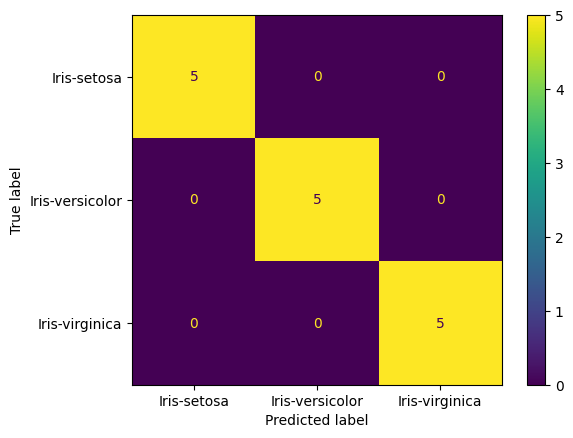

In [ ]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= classes)
disp.plot();